# TYP Plots

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm
from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

from matplotlib import gridspec

In [5]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [3]:
#12 model colours for 12 models, generated using https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']


#### Plot the COM and TYP experiments melt rate below 300m

In [7]:
sPerYr = 3600*24*365

In [8]:
modelcoloursTYP=['#1f78b4','#fdbf6f','#ff7f00','#cab2d6','#cab2d6','#6a3d9a','#ffff99','#b15928','#b15928']
modelstylesTYP = ['-','-','-','-','--','-','-','-','--']

#### Now put everything together in one plot:

with colours matching

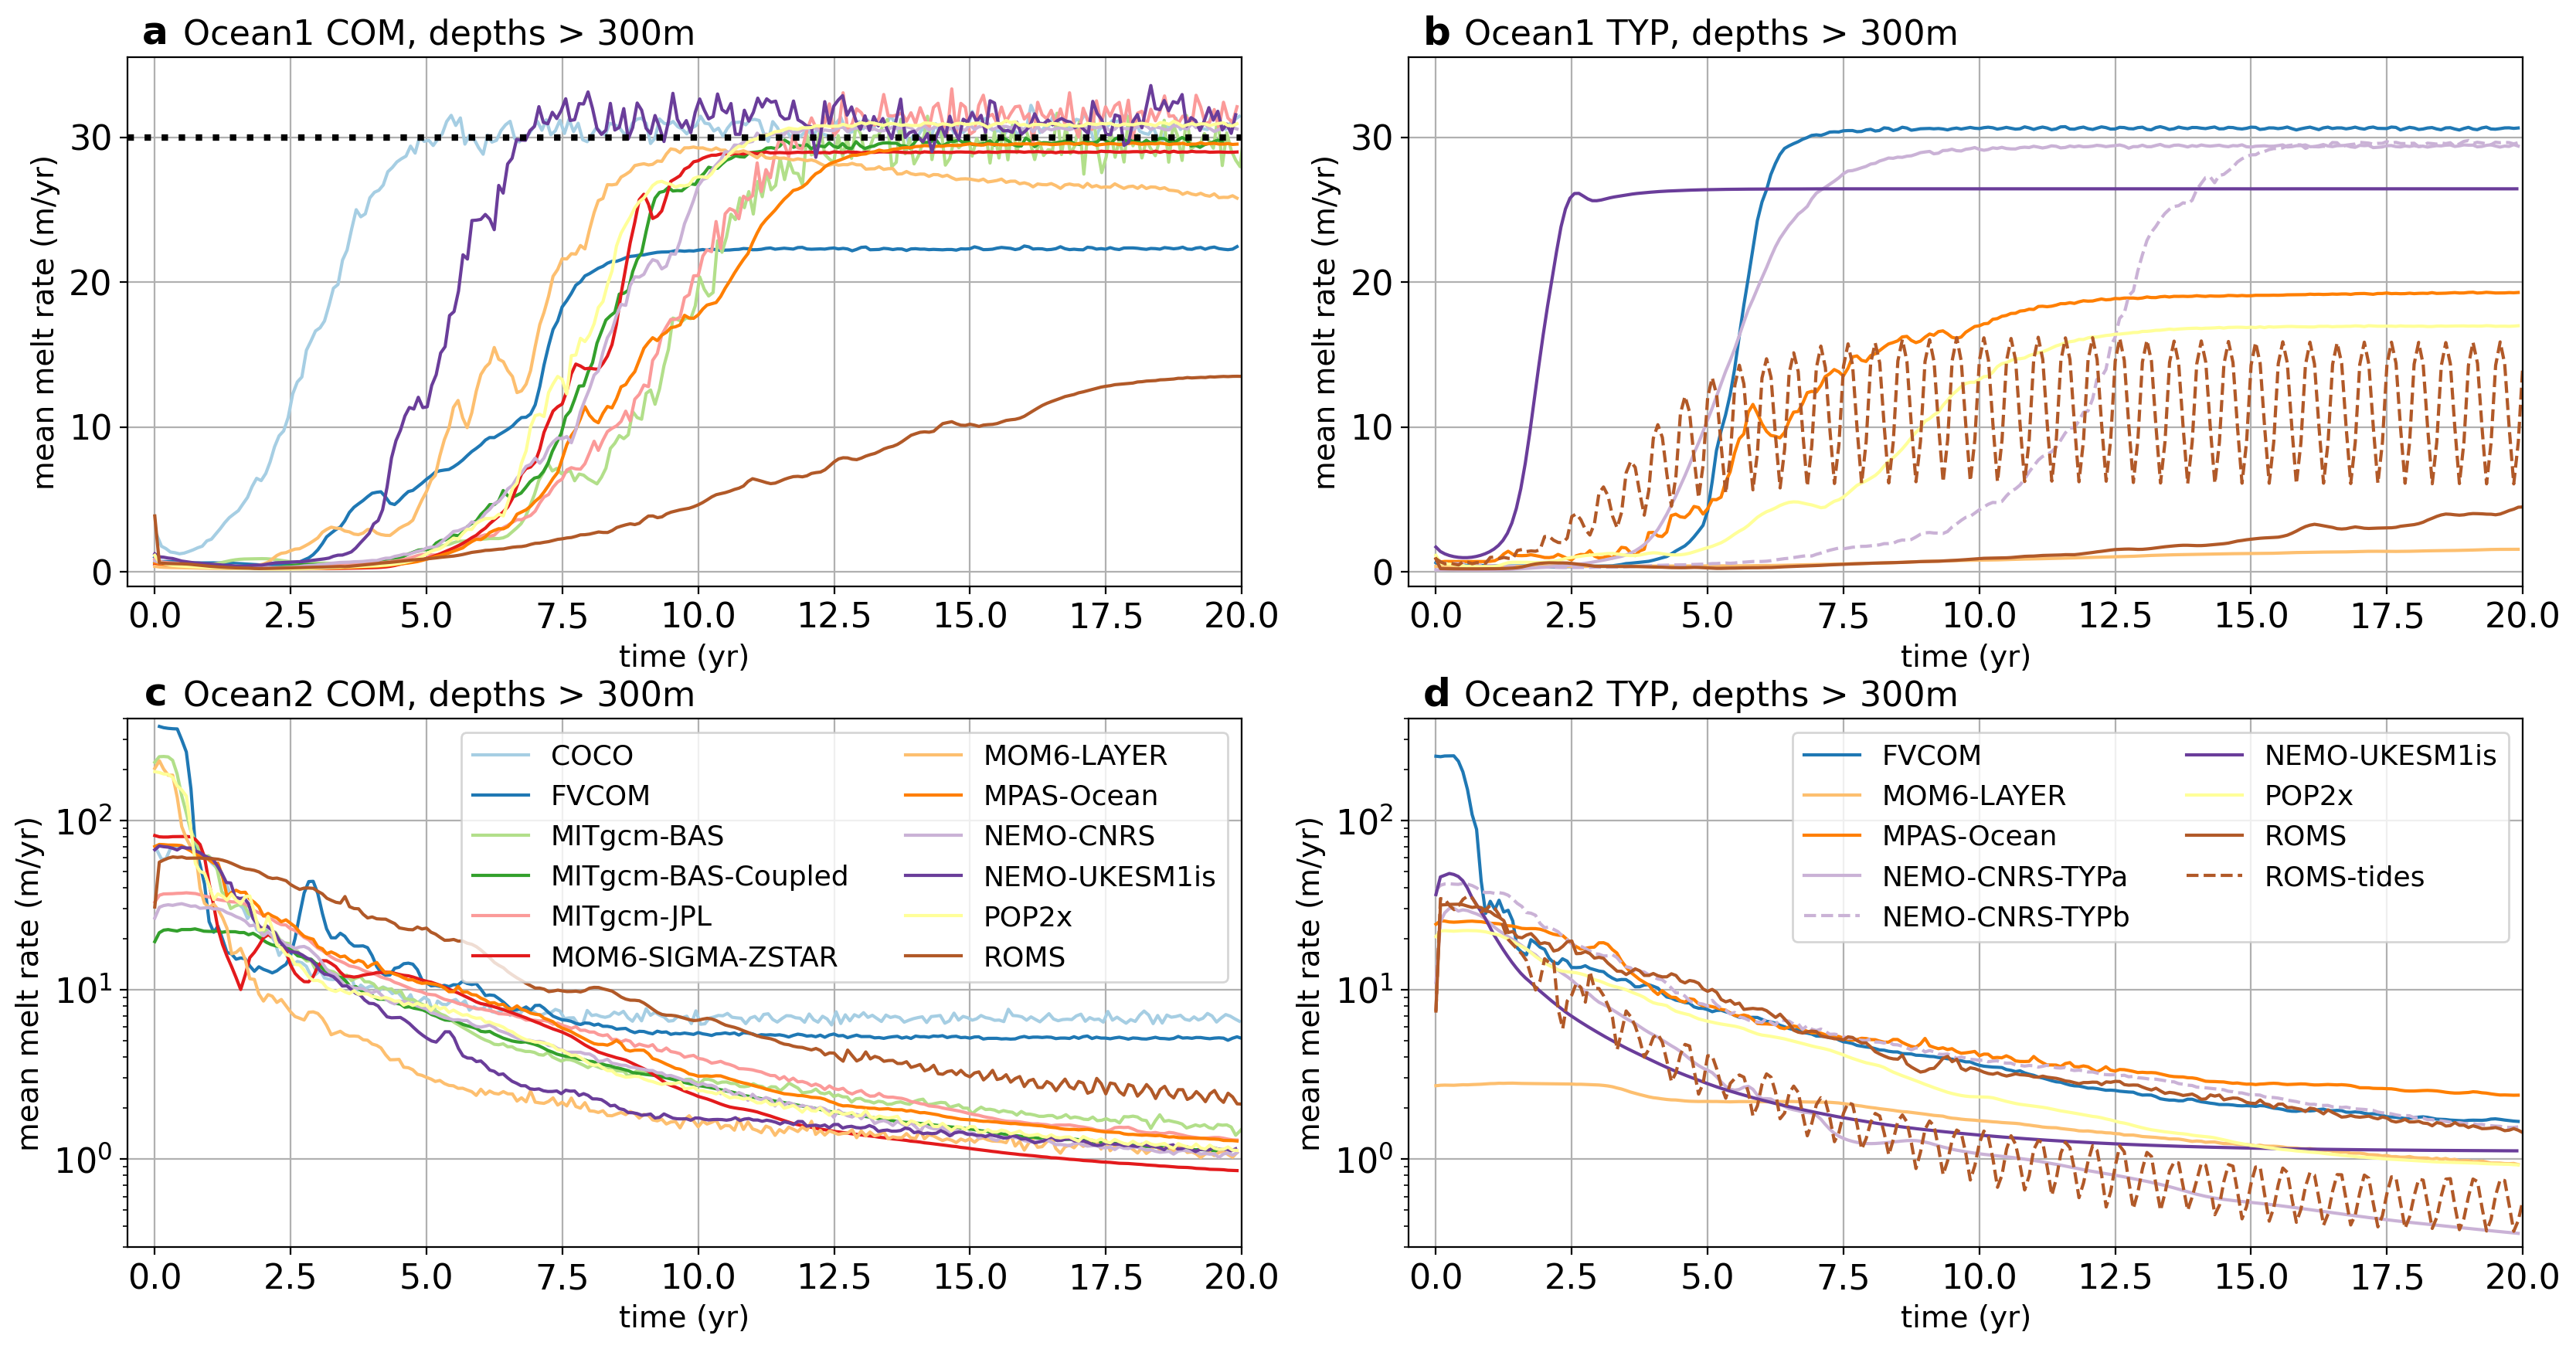

In [12]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
fig = plt.figure(figsize = (20,10),facecolor='w',dpi = 200)


for k in np.arange(4):
    expt = [Ocean1_COM,Ocean1_TYP,Ocean2_COM,Ocean2_TYP][k]
    ax = plt.subplot(2,2,k+1)
    title = ['Ocean1 COM, depths > 300m','Ocean1 TYP, depths > 300m',
             'Ocean2 COM, depths > 300m',
             'Ocean2 TYP, depths > 300m'][k]
    labels = get_labels(expt)
    length = len(expt)
        
    for i in np.arange(length):
        ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
        # make x and y coordinates
        ds = ds.set_coords(['x', 'y', 'time'])
        nTime = ds.sizes['nTime']
        mr = ds.meltRate
        
        try:
            draft = ds.iceDraft.isel(nTime = 0)
        except ValueError:
            draft = ds.iceDraft
        # mr < 1e36 is to get rid of fill values.
        mr = sPerYr * mr.where(mr < 1e36).where(mr !=0).where(np.abs(draft) > 300)
        time = ds.time
        if (k==0 or k==2):
            plt.plot(time.values/sPerYr,mr.mean(['nx','ny']).values,
                     color = modelcolours[i], label = labels[i])
        else: # plot TYP colours
            plt.plot(time.values/sPerYr,mr.mean(['nx','ny']).values,
                     color = modelcoloursTYP[i], label = labels[i], linestyle = modelstylesTYP[i])
    
    
    plt.ylabel('mean melt rate (m/yr)', fontsize = 14)
    plt.xlabel('time (yr)', fontsize = 14)
    plt.xlim(-0.5,20)
    plt.text(0.025,1.045,['a','b','c','d'][k],horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax.transAxes, fontsize = 18)
    plt.tick_params(labelsize=16)

    # add 30m line for Ocean1
    if k==0:
        plt.hlines([30],-0.5,20,color ='k', linestyle = 'dotted',linewidth = 3,label = '30m/yr')

    if (k==0 or k==1):
        plt.ylim(-1,35.5)
    else:
        plt.ylim(0.3,400)
        plt.yscale('log')
        plt.legend(ncols = 2, fontsize = 13)


    plt.grid()
    plt.title(title, fontsize=16,ha='left', x=0.05);

fig.subplots_adjust(hspace = 0.25, wspace = 0.15)



# Plot TYP u* and T* statistics


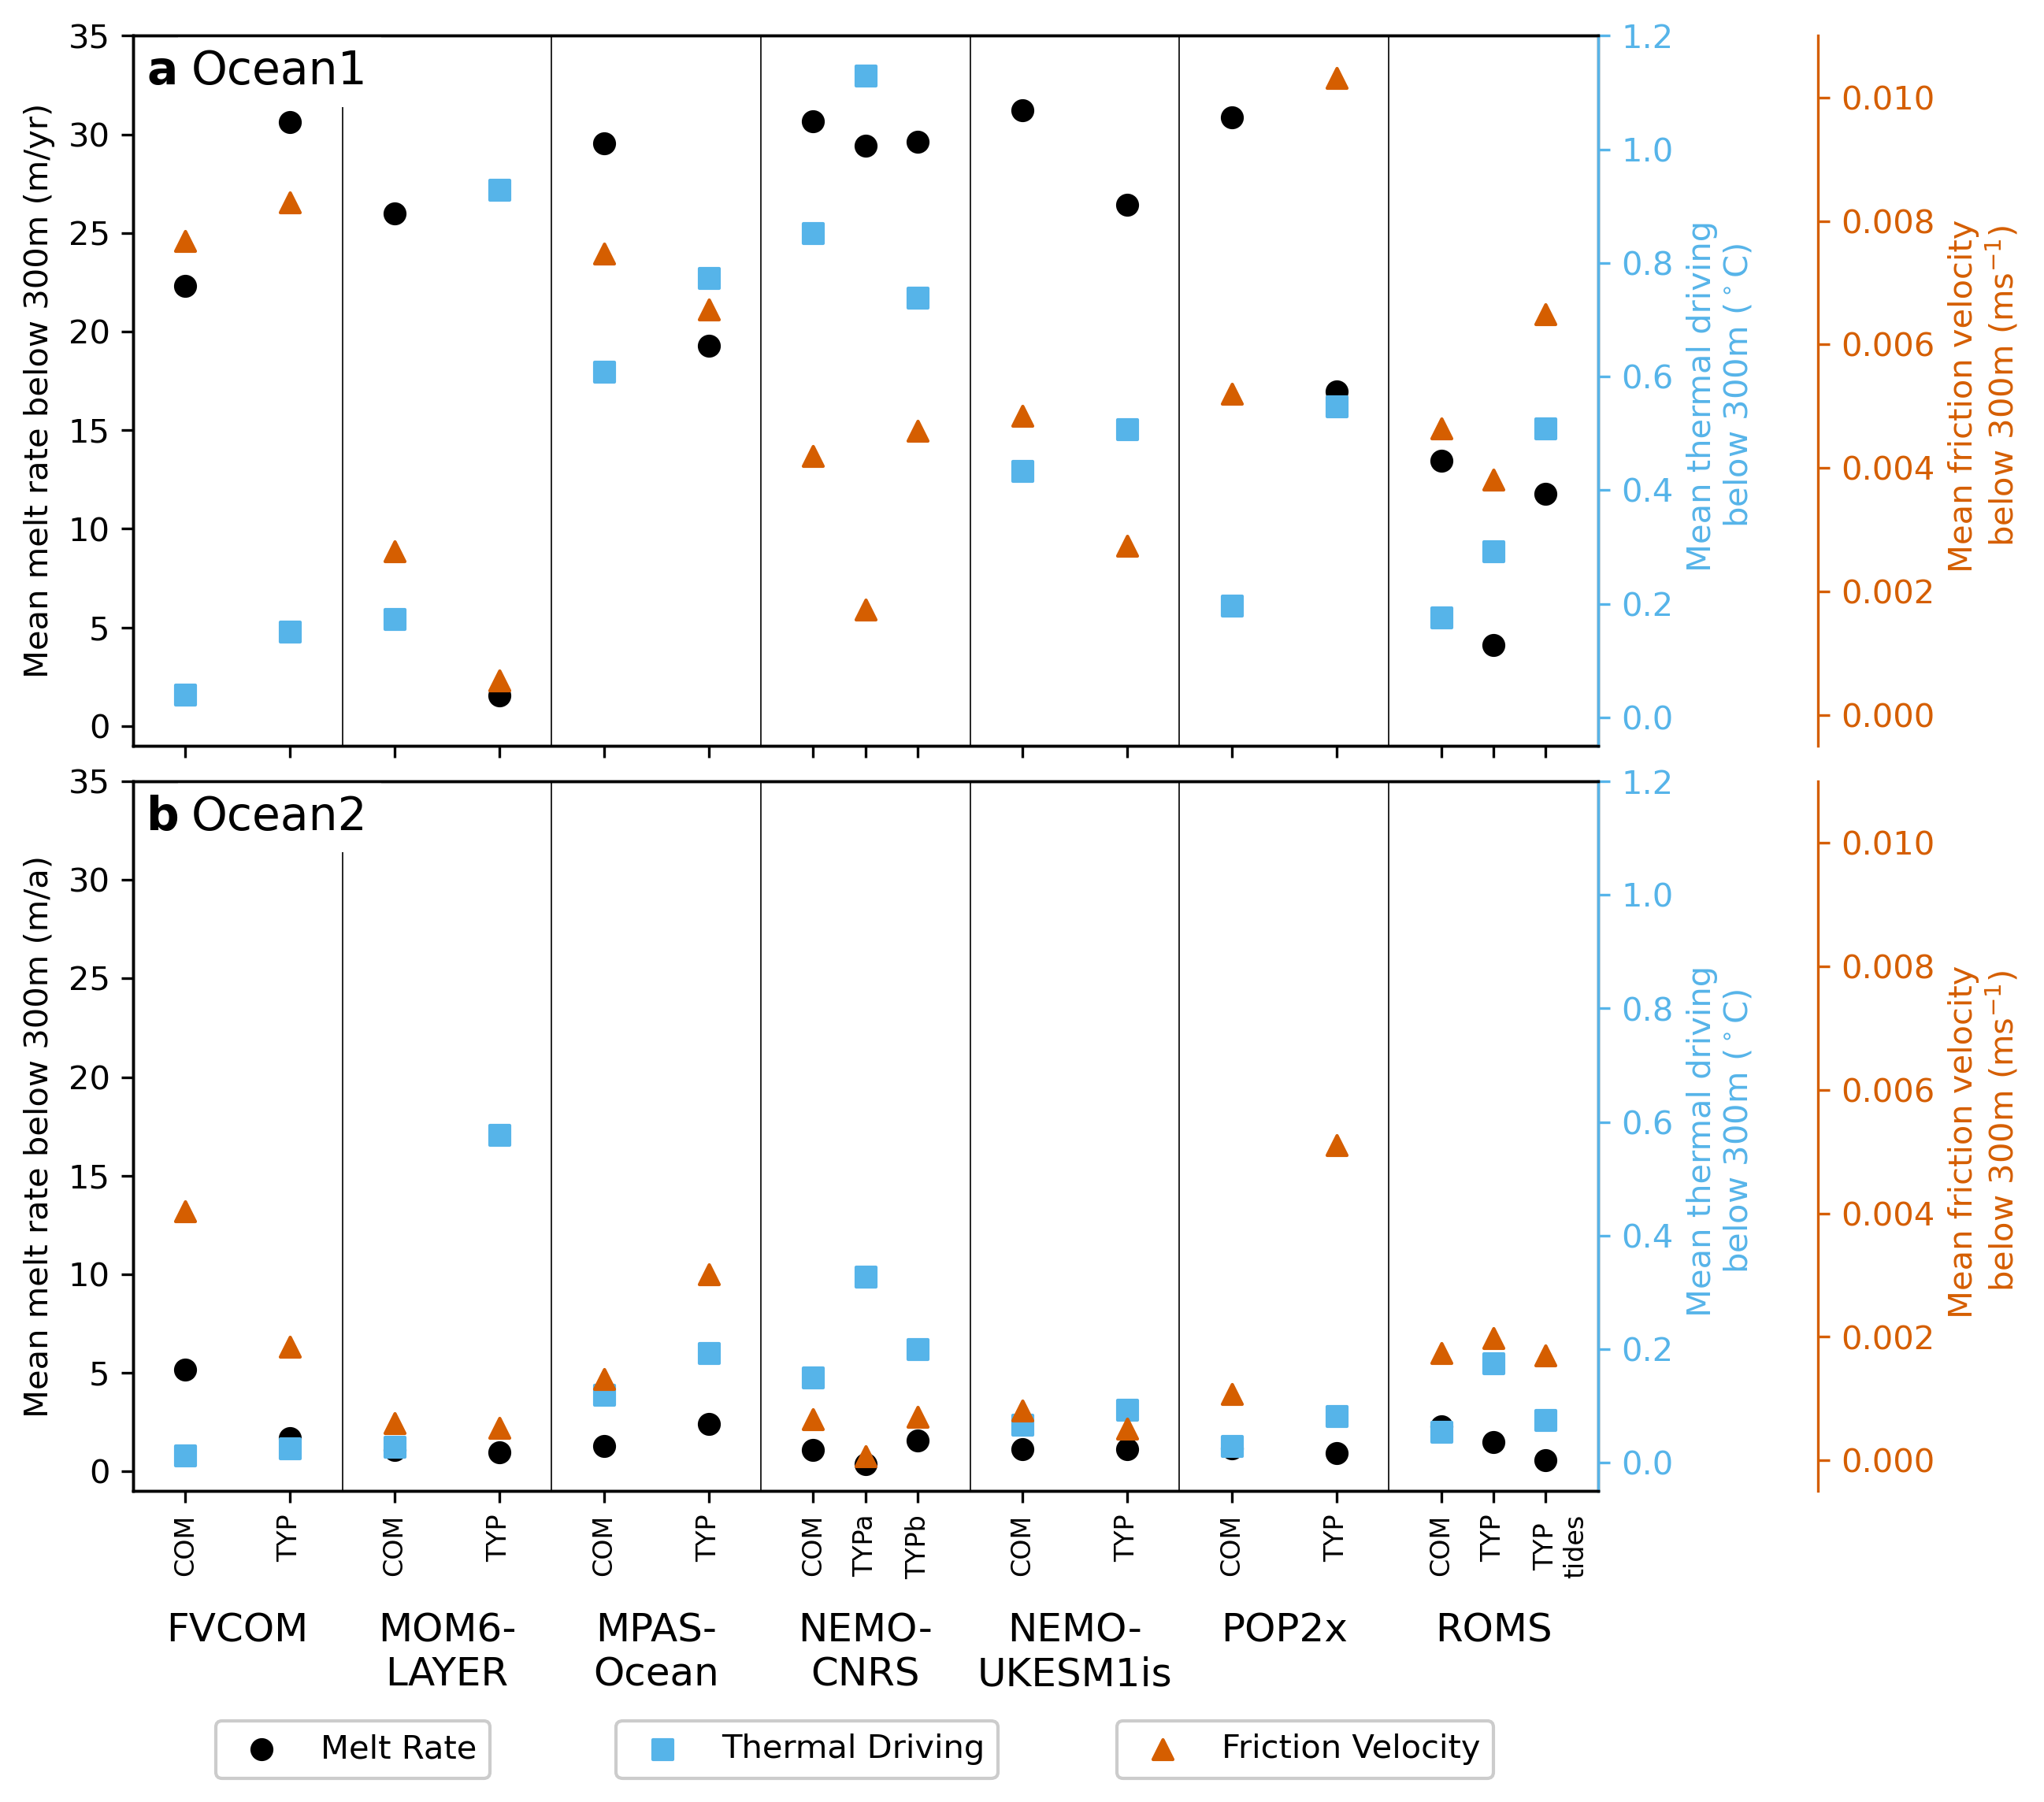

In [17]:
#create figure

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.15, hspace=0.05)
fig = plt.figure(figsize=(8,8),facecolor='w',dpi = 300)

ax=fig.add_subplot(gs[0])
ax4=fig.add_subplot(gs[1])

color_palette = ['#000000','#56B4E9','#D55E00']

### Ocean1 first

expt = np.take(Ocean1_COM,[1,6,7,8,9,10,11]) #pick out only COM experiments with TYPs
labels = get_labels(expt)

length = len(expt)

ts = []
us = []
ms = []

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    try:
        draft = data.iceDraft.isel(nTime = 0)
    except ValueError:
        draft = data.iceDraft
    # mr < 1e36 is to get rid of fill values.
    melt = sPerYr * melt.where(melt < 1e36).where(melt !=0).where(np.abs(draft) > 300)
    melt_av = (melt.where(melt<1e36)).mean(['nx','ny'])
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar = tstar.where(np.abs(draft) > 300)
    tstar_av = (tstar.where(tstar<1e36)).mean(['nx','ny'])
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar = ustar.where(np.abs(draft) > 300)
    ustar_av = (ustar.where(ustar<1e36)).mean(['nx','ny'])

    ms = np.append(ms,melt_av)
    ts = np.append(ts,tstar_av)
    us = np.append(us,ustar_av)

# plot mr scatter
CS1 = ax.scatter(np.arange(7)-0.25,ms,color = color_palette[0], label = 'Melt Rate')

# make new yaxis, plot thermal driving
ax2 = ax.twinx()
CS2= ax2.scatter(np.arange(7)-0.25,ts,color = color_palette[1],marker = 's', label = 'Thermal Driving')
# make new yaxis, plot fric vel
ax3 = ax.twinx()
ax3.spines.right.set_position(("axes", 1.15))
CS3 = ax3.scatter(np.arange(7)-0.25,us,color = color_palette[2], marker = '^',label = 'Friction Velocity')

#set xticks and hide them 
ax.set_xticks([-0.25,0.25,0.75,1.25,1.75,2.25,2.75,3,3.25,3.75,4.25,4.75,5.25,5.75,6,6.25])
ax.set_xticklabels('')

#set colors of yaxis
ax.spines['left'].set_color(color_palette[0])
ax.tick_params(axis='y', colors=color_palette[0])

ax2.spines['right'].set_color(color_palette[1])
ax2.tick_params(axis='y', colors=color_palette[1])

ax3.spines['right'].set_color(color_palette[2])
ax3.tick_params(axis='y', colors=color_palette[2])

#set yaxis labels
ax.set_ylabel(r'Mean melt rate below 300m (m/yr)',color = color_palette[0])
ax2.set_ylabel('Mean thermal driving \n'+r' below 300m ($^\circ$C)',color = color_palette[1])
ax3.set_ylabel('Mean friction velocity \n'+r' below 300m (ms$^{-1}$)',color = color_palette[2])


##### now do the same for TYP

expt = Ocean1_TYP
labels = get_labels(expt)

length = len(expt)

ts = []
us = []
ms = []

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    try:
        draft = data.iceDraft.isel(nTime = 0)
    except ValueError:
        draft = data.iceDraft
    # mr < 1e36 is to get rid of fill values.
    melt = sPerYr * melt.where(melt < 1e36).where(melt !=0).where(np.abs(draft) > 300)
    melt_av = (melt.where(melt<1e36)).mean(['nx','ny'])
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar = tstar.where(np.abs(draft) > 300)
    tstar_av = (tstar.where(tstar<1e36)).mean(['nx','ny'])
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar = ustar.where(np.abs(draft) > 300)
    ustar_av = (ustar.where(ustar<1e36)).mean(['nx','ny'])

    ms = np.append(ms,melt_av)
    ts = np.append(ts,tstar_av)
    us = np.append(us,ustar_av)

CS4 = ax.scatter([0.25,1.25,2.25,3,3.25,4.25,5.25,6,6.25],ms,color = color_palette[0],marker = 'o', label = 'Melt Rate')
CS5 = ax2.scatter([0.25,1.25,2.25,3,3.25,4.25,5.25,6,6.25],ts,color = color_palette[1],marker = 's', label = 'Thermal Driving')
CS6 = ax3.scatter([0.25,1.25,2.25,3,3.25,4.25,5.25,6,6.25],us,color = color_palette[2], marker = '^', label = 'Friction Velocity')

ax.vlines(np.arange(7)+0.5,-1,35,color = 'k', linewidth = 0.4)
ax.set_ylim(-1,35)
ax2.set_ylim(-0.05,1.2)
ax3.set_ylim(-0.0005,0.011)
ax.set_xlim(-0.5,6.5)

###Ocean 2


expt = np.take(Ocean2_COM,[1,6,7,8,9,10,11]) #pick out only COM experiments with TYPs
labels = get_labels(expt)
length = len(expt)

ts = []
us = []
ms = []

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    try:
        draft = data.iceDraft.isel(nTime = 0)
    except ValueError:
        draft = data.iceDraft
    # mr < 1e36 is to get rid of fill values.
    melt = sPerYr * melt.where(melt < 1e36).where(melt !=0).where(np.abs(draft) > 300)
    melt_av = (melt.where(melt<1e36)).mean(['nx','ny'])
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar = tstar.where(np.abs(draft) > 300)
    tstar_av = (tstar.where(tstar<1e36)).mean(['nx','ny'])
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar = ustar.where(np.abs(draft) > 300)
    ustar_av = (ustar.where(ustar<1e36)).mean(['nx','ny'])

    ms = np.append(ms,melt_av)
    ts = np.append(ts,tstar_av)
    us = np.append(us,ustar_av)

# plot melt rate scatter
CS1 = ax4.scatter(np.arange(7)-0.25,ms,color = color_palette[0], label = 'Melt Rate')

# make new axis, plot thermal driving scatter
ax5 = ax4.twinx()
CS2= ax5.scatter(np.arange(7)-0.25,ts,color = color_palette[1],marker = 's', label = 'Thermal Driving')
#make new axis, plot fric velocity scatter
ax6 = ax4.twinx()
ax6.spines.right.set_position(("axes", 1.15))
CS3 = ax6.scatter(np.arange(7)-0.25,us,color = color_palette[2], marker = '^',label = 'Friction Velocity')

#set labels on x axis
ax4.set_xticks([-0.25,0.25,0.75,1.25,1.75,2.25,2.75,3,3.25,3.75,4.25,4.75,5.25,5.75,6,6.25])
ax4.set_xticklabels(['COM','TYP',
                     'COM','TYP',
                     'COM','TYP',
                     'COM','TYPa','TYPb',
                     'COM','TYP',
                     'COM','TYP',
                     'COM','TYP','\nTYP\ntides'],rotation = 90, fontsize = 8)
#set colors of yaxes
ax4.spines['left'].set_color(color_palette[0])
ax4.tick_params(axis='y', colors=color_palette[0])

ax5.spines['right'].set_color(color_palette[1])
ax5.tick_params(axis='y', colors=color_palette[1])

ax6.spines['right'].set_color(color_palette[2])
ax6.tick_params(axis='y', colors=color_palette[2])

#set yaxes labels
ax4.set_ylabel(r'Mean melt rate below 300m (m/a)',color = color_palette[0])
ax5.set_ylabel('Mean thermal driving \n'+r' below 300m ($^\circ$C)',color = color_palette[1])
ax6.set_ylabel('Mean friction velocity \n'+r' below 300m (ms$^{-1}$)',color = color_palette[2])

#Add a legend for each point

ax4.legend(loc = 'upper center', bbox_to_anchor = (0.15,-0.3),facecolor='white', framealpha=1)
ax5.legend(loc = 'upper center', bbox_to_anchor = (0.46,-0.3),facecolor='white', framealpha=1)
ax6.legend(loc = 'upper center', bbox_to_anchor = (0.8,-0.3),facecolor='white', framealpha=1)

##### now do the same for TYP

expt = Ocean2_TYP
labels = get_labels(expt)

length = len(expt)

ts = []
us = []
ms = []

for i in np.arange(length):

    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    time = len(data.nTime)
    melt = (data.meltRate).isel(nTime = np.arange(time-13,time)).mean('nTime')
    try:
        draft = data.iceDraft.isel(nTime = 0)
    except ValueError:
        draft = data.iceDraft
    # mr < 1e36 is to get rid of fill values.
    melt = sPerYr * melt.where(melt < 1e36).where(melt !=0).where(np.abs(draft) > 300)
    melt_av = (melt.where(melt<1e36)).mean(['nx','ny'])
    tstar = data.thermalDriving.isel(nTime = np.arange(time-13,time)).mean('nTime')
    tstar = tstar.where(np.abs(draft) > 300)
    tstar_av = (tstar.where(tstar<1e36)).mean(['nx','ny'])
    ustar = data.frictionVelocity.isel(nTime = np.arange(time-13,time)).mean('nTime')
    ustar = ustar.where(np.abs(draft) > 300)
    ustar_av = (ustar.where(ustar<1e36)).mean(['nx','ny'])

    ms = np.append(ms,melt_av)
    ts = np.append(ts,tstar_av)
    us = np.append(us,ustar_av)

# plot scatters on different axes
CS4 = ax4.scatter([0.25,1.25,2.25,3,3.25,4.25,5.25,6,6.25],ms,color = color_palette[0],marker = 'o', label = 'Melt Rate')
CS5 = ax5.scatter([0.25,1.25,2.25,3,3.25,4.25,5.25,6,6.25],ts,color = color_palette[1],marker = 's', label = 'Thermal Driving')
CS6 = ax6.scatter([0.25,1.25,2.25,3,3.25,4.25,5.25,6,6.25],us,color = color_palette[2], marker = '^', label = 'Friction Velocity')

ax4.vlines(np.arange(7)+0.5,-1,35,color = 'k', linewidth = 0.4)
#ax4.set_ylim(-0.5,6)
ax4.set_ylim(-1,35)
ax5.set_ylim(-0.05,1.2)
ax6.set_ylim(-0.0005,0.011)

ax4.set_xlim(-0.5,6.5)

## Add some labels
ax.text(0.02,0.95,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax.transAxes, fontsize = 14)
t = ax.text(0.1,0.95,'Ocean1',horizontalalignment='center', 
     verticalalignment='center',transform=ax.transAxes, fontsize = 14)
t.set_bbox(dict(facecolor='white', alpha=1, linewidth=0))
ax4.text(0.02,0.95,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax4.transAxes, fontsize = 14)
t = ax4.text(0.1,0.95,'Ocean2',horizontalalignment='center', 
     verticalalignment='center',transform=ax4.transAxes, fontsize = 14)
t.set_bbox(dict(facecolor='white', alpha=1, linewidth=0))

## Add model labels
for i in np.arange(7):
    label_short = ['FVCOM','MOM6-\nLAYER','MPAS-\nOcean','NEMO-\nCNRS','NEMO-\nUKESM1is','POP2x','ROMS'][i]
    ax4.text((2*i+1)/14,-0.17,label_short,horizontalalignment='center', 
         verticalalignment='top',transform=ax4.transAxes, fontsize = 12)

fig.align_ylabels([ax,ax4])
